# Training a counterfactually fair CAD model

## Counterfactual Fairness

Attempts to mitigate bias in a model by simply removing sensitive attributes from its training, i.e. fairness by unawareness, often fails due to bias 'leaking' through causal relationships between the sensitive attribute and other features retained in the data. The counterfactual fairness approach introduced by Kusner et al. (2017, in Advances in Neural Information Processing Systems, https://proceedings.neurips.cc/paper_files/paper/2017/file/a486cd07e4ac3d270571622f4f316ec5-Paper.pdf) addresses this limitation by deconvoluting the biased observed variables into a fair set of unbiased latent variables. It allows the model to only learn from information that is independent from the protected attribute, and neutralise both direct and proxy bias pathways.

### Notations and definitions

we adopt the following notations consistent with the Pearlian causal framework used by Kusner et al.:

- $S$ **Protected attribute**: The sensitive variable we wish to be fair toward
- $X$ **Observed features**: The set of features available in the dataset (e.g. Blood Pressure, Cholesterol)
- $U$ **Latent (unobserved) variables**: Unobserved variables that are independent of the protected attribute $A$
- $Y$ **Target**: The outcome we are predicting (e.g. Presence of CAD)
- $Y_{S \leftarrow s}$: The value of $Y$ under a counterfactual intervention where $S$ is set to $s$
- $M = (U, V, F)$ a causal model corresponding to the observed data, where $V \equiv X \cup Y \cup S$, and $F$ is the set of structural equations of the model

**Counterfactual Fairness:** A predictor $\hat{Y}$ is counterfactually fair if, for a specific individual, the probability distribution of the prediction is the same in the actual world as it would be in a counterfactual world where their protected attribute (e.g., Sex) was different.

Formally, for any value $a'$ of the protected attribute $A$:$$P(\hat{Y}_{S \leftarrow s} = y \mid X=x, S=s) = P(\hat{Y}_{S \leftarrow s'} = y \mid X=x, S=s')$$

---


## The experiment

Using the fairness-unaware models trained to predict Cardiovascular Disease in Straw et al. (2024, doi: [10.2196/46936](https://doi.org/10.2196/46936)) as baseline models, we will apply the fairness algorithm proposed by Kusner et al. to train a fair CAD predictor.

### The target bias
While Kusner focus on mitigating bias on tasks where the protected attribute should have no influence on the target outcome (e.g. sex and exam results), the clinical domain brings a new challenge. Indeed, protected attributes such as sex or race often encompass two variables: the clinically relevant biological attribute which can cause a disease to present differently across individuals, and the sociological attribute which has societal factors that can influence healthcare access, physician perception, diagnosis and care. A clinical outcome might be influenced by the former but should remain independent of the latter.

If we aim for fairness based on the high-level sex attribute, we risk removing legitimate clinical signals and degrading diagnostic accuracy. Therefore, our objective in experiment is to make the model counterfactually fair with regards to **sociological sex**.

### Hypothesis

By using counterfactual inference to model latent variables that are independent of the protected attribute, we can build a predictor that satisfies counterfactual fairness (i.e. ensuring that an individual’s predicted risk of CAD remains invariant to their sociological sex), while maintaining clinically acceptable predictive performance and reducing the False Negative Rate (FNR) disparity observed in baseline models.

---

## Causal models

From the feature set observed in the [Heart Disease (CAD) dataset](https://ieee-dataport.org/open-access/heart-disease-dataset-comprehensive), using clinical knowledge in the literature and strong assumptions, we create two causal models that we will compare in this experiment:

### Latent variables model

We hypothesise that clinical features in the CAD dataset are manifestations of a patient's **Age- and Sex-independent Physiological Integrity**, which we define as our fair latent variable $U$. It is independent of the protected attributes $S_{bio}$ and $S_{soc}$.

We postulate thatsubjective symptoms and clinician-dependent interpretations are influenced by Sociological Sex ($S_{soc}$). This creates an unfair pathway where the recorded value of a feature is not solely a manifestation of the patient's physiological state, but is also a product of external factors:
- Reporting bias: how a patient describes symptoms like chest pain based on gendered expectations
- Diagnostic bias: how a clinician interprets those symptoms, potentially mislabeling 'atypical' presentations in women

We assume that objective biomarkers such as cholesterol, maximum heart rate, resting blood pressure, fasting blood sugar, and measurements related to the ECG ST slope, are only influenced by the **biological sex** ($S_{bio}$), and are therefore fair pathways for the predictor.

Age is considered as the sole independent variable from $S_{bio}$ and $S_{soc}$.

**Structural equations:**

| Feature | Variable name | Variable type | Model distribution |
|:---|:---|:---|:---|
|Chest Pain Type | $CP$|Categorical|Categorical|
|Exercise Induced Angina | $Ang$|Binary|Bernoulli|
|Resting ECG Result | $ECG$|Categorical|Categorical|
|Max Heart Rate |$MHR$ |Numerical| Normal |
|Fasting Blood Sugar |$FBS$ |Binary|Bernoulli|
|Oldpeak |$ST$ |Numerical| Zero-Inflated Log-Normal |
|ST Slope |$Slope$ |Categorical|Categorical|
|Resting Blood Pressure | $BP$|Numerical| Normal |
|Serum Cholesterol | $Chol$ |Numerical| Log-Normal |
|Age- and Sex-independent Physiological Integrity | $U$|Numerical| Normal |
|Cardiovascular Disease (target outcome) | $Y$|Binary|Bernoulli|

<br>

- $CP = f_{CP}(U, S_{soc}, Age) \sim \text{Categorical}(\text{softmax}(\alpha_{CP} + \beta_{CP, U}U + \beta_{CP,S_{soc}}S_{soc} + \beta_{CP,Age}Age))$

- $Ang = f_{Ang}(U, S_{soc}, Age) \sim  \text{Bernoulli}(\text{invlogit}(\alpha_{Ang} + \beta_{Ang, U}U + \beta_{Ang,soc}S_{soc} + \beta_{Ang,Age}Age))$

- $ECG = f_{ECG}(U, S_{soc}, Age) \sim \text{Categorical}(\text{softmax}(\alpha_{ECG} + \beta_{ECG, U}U + \beta_{ECG,soc}S_{soc} + \beta_{ECG,Age}Age))$

- $MHR = f_{MHR}(U, S_{bio}, Age) \sim \mathcal{N}(\alpha_{MHR} + \beta_{MHR,U}U + \beta_{MHR,bio}S_{bio} + \beta_{MHR,Age}Age, \sigma_{MHR})$

- $FBS = f_{FBS}(U, S_{bio}, Age) \sim \text{Bernoulli}(\text{invlogit}(\alpha_{FBS} + \beta_{FBS,U}U + \beta_{FBS,bio}S_{bio} + \beta_{FBS,Age}Age))$

- $ST = f_{ST}(U, S_{bio}, Age) \sim \text{ZeroInflatedLogNormal}(\psi_{ST}, \mu_{ST}, \sigma_{ST})$

  - where $\psi_{ST} = \text{invlogit}(\alpha_{\psi} + \beta_{\psi,U}U + \beta_{\psi,bio}S_{bio} + \beta_{\psi,Age}Age)$
  - and $\mu_{ST} = \alpha_{\mu} + \beta_{\mu,U}U + \beta_{\mu,bio}S_{bio}  + \beta_{\mu,Age}Age$

- $Slope =f_{Slope}(U, S_{bio}, Age) \sim \text{Categorical}(\text{softmax}(\alpha_{Slope} + \beta_{Slope, U}U + \beta_{Slope,bio}S_{bio} + \beta_{Slope,Age}Age)) $

- $BP = f_{BP}(U, S_{bio}, Age) \sim \mathcal{N}(\alpha_{BP} + \beta_{BP,U}U + \beta_{BP,bio}S_{bio} + \beta_{BP,Age}Age, \sigma_{BP})$

- $Chol=  f_{Chol}(U, S_{bio}, Age) \sim \text{LogNormal}(\alpha_{Chol} + \beta_{Chol,U}U + \beta_{Chol,bio}S_{bio} + \beta_{Chol,Age}Age, \sigma_{Chol}$

- $Y = f_{Y}(U, S_{bio}, Age) \sim \text{Bernoulli}(\text{invlogit}(\alpha_{Y} + \beta_{Y, U}U + \beta_{Y,bio}S_{bio} + \beta_{Y,Age}Age)) $

- $U \sim \mathcal{N}(0, 1) $

<br>

### Additive error model




In [3]:
try:
  from google.colab import userdata
  from google.colab import drive
  drive.mount('/content/drive')
  PROJECT_ROOT = userdata.get('PROJECT_ROOT')
except ImportError:
  PROJECT_ROOT = '/'

Mounted at /content/drive


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm

In [26]:
heart_disease = pd.read_csv(f'{PROJECT_ROOT}data/heart_disease_cleveland_hungary.csv')

# Remove duplicates and null values, as per Straw et al.

rows_to_drop  = (heart_disease['cholesterol'] == 0) | (heart_disease['resting bp s'] == 0) | (heart_disease.duplicated(keep='first'))
heart_disease.drop(heart_disease[rows_to_drop].index, inplace=True)



heart_disease['s_bio'] = heart_disease['sex']
heart_disease.rename(columns={'sex':'s_soc', 'chest pain type':'cp', 'resting bp s':'bp', 'cholesterol':'chol',
                              'fasting blood sugar':'fbs', 'resting ecg':'ecg', 'max heart rate':'mhr', 'exercise angina':'ang',
                              'oldpeak':'st', 'ST slope':'slope', 'target':'cvd'}, inplace=True)

# Clip negative values of st (oldpeak)
heart_disease['st'] = heart_disease['st'].clip(lower=0)

heart_disease.describe()

,age,s_soc,cp,bp,chol,fbs,ecg,mhr,ang,st,slope,cvd,s_bio
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,0.756032,3.163539,133.022788,244.635389,0.167560,0.639410,140.226542,0.384718,0.901743,1.587131,0.477212,0.756032
std,9.505888,0.429762,0.955414,17.282750,59.153524,0.373726,0.838664,24.524107,0.486855,1.072742,0.600712,0.499816,0.429762
min,28.000000,0.000000,1.000000,92.000000,85.000000,0.000000,0.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,1.000000,2.000000,120.000000,207.250000,0.000000,0.000000,122.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,54.000000,1.000000,3.000000,130.000000,237.000000,0.000000,0.000000,140.000000,0.000000,0.500000,2.000000,0.000000,1.000000
75%,59.000000,1.000000,4.000000,140.000000,275.000000,0.000000,1.000000,160.000000,1.000000,1.500000,2.000000,1.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000,1.000000


In [27]:
with pm.Model() as causal_model:
  # 1. EVIDENCE & PRIORS:
  # Fixed predictors
  age = heart_disease['age']
  s_bio = heart_disease['s_bio']
  s_soc = heart_disease['s_soc']

  # The prior for U, the age- and sex- independent physiological integrity
  # we need to infer from the observed evidence, i.e. the dataset
  U = pm.Normal('U', mu=0, sigma=1, shape=len(heart_disease))

  # Parameter priors
  non_zero_st = heart_disease['st'][heart_disease['st'] > 0]
  alpha_init_st = np.log(non_zero_st.mean()) if len(non_zero_st) > 0 else 0
  alpha_init = np.zeros(11)
  alpha_init[10] = alpha_init_st
  alpha = pm.Normal('alpha', mu=0, sigma=1, shape=11, initval=alpha_init)
  beta_U = pm.Normal('beta_U', mu=0, sigma=1, shape=11)
  beta_soc = pm.Normal('beta_soc', mu=0, sigma=1, shape=3)
  beta_bio = pm.Normal('beta_bio', mu=0, sigma=1, shape=8)
  beta_age = pm.Normal('beta_age', mu=0, sigma=1, shape=11)
  sigma = pm.HalfNormal('sigma', sigma=1, shape=4)

  # 2. LIKELIHOODS: Variables likelihoods
  cp = pm.Categorical('cp',
            logit_p=alpha[0] + beta_U[0]*U + beta_soc[0]*s_soc + beta_age[0]*age,
            observed=heart_disease['cp'])

  ang = pm.Bernoulli('ang',
            logit_p=alpha[1] + beta_U[1]*U + beta_soc[1]*s_soc + beta_age[1]*age,
            observed=heart_disease['ang'])

  ecg = pm.Categorical('ecg',
            logit_p=alpha[2] + beta_U[2]*U + beta_soc[2]*s_soc + beta_age[2]*age,
            observed=heart_disease['ecg'])

  mhr = pm.Normal('mhr',
            mu=alpha[3] + beta_U[3]*U + beta_bio[0]*s_bio + beta_age[3]*age,
            sigma=sigma[0],
            observed=heart_disease['mhr'])

  fbs = pm.Bernoulli('fbs',
            logit_p=alpha[4] + beta_U[4]*U + beta_bio[1]*s_bio + beta_age[4]*age,
            observed=heart_disease['fbs'])

  slope = pm.Categorical('slope',
            logit_p=alpha[5] + beta_U[5]*U + beta_bio[2]*s_bio + beta_age[5]*age,
            observed=heart_disease['slope'])

  bp = pm.Normal('bp',
            mu=alpha[6] + beta_U[6]*U + beta_bio[3]*s_bio + beta_age[6]*age,
            sigma=sigma[1],
            observed=heart_disease['bp'])

  chol = pm.LogNormal('chol',
            mu=alpha[7] + beta_U[7]*U + beta_bio[4]*s_bio + beta_age[7]*age,
            sigma=sigma[2],
            observed=heart_disease['chol'])

  cvd = pm.Bernoulli('cvd',
            logit_p=alpha[8] + beta_U[8]*U + beta_bio[5]*s_bio + beta_age[8]*age,
            observed=heart_disease['cvd'])

  # CUSTOM DIST. for Oldpeak (ST): Zero-inflated Log-normal
  # Probability of being exactly zero
  psi_st = pm.math.invlogit(alpha[9] + beta_U[9]*U + beta_bio[6]*s_bio + beta_age[9]*age)
  # Log-normal parameters
  mu_st = alpha[10] + beta_U[10]*U + beta_bio[7]*s_bio + beta_age[10]*age
  sigma_st = sigma[3]

  # Probability function for the custom distribution
  def zero_inflated_lognormal(value, psi, mu, sigma):
    # Log-probability for the zero cases
    logp_zero = pm.math.log(psi)

    # Log-probability for the non-zero cases
    safe_value = pm.math.switch(pm.math.eq(value, 0), 1.0, value)
    logp_nonzero = pm.math.log(1 - psi) + pm.logp(pm.LogNormal.dist(mu=mu, sigma=sigma), safe_value)

    return pm.math.switch(pm.math.eq(value, 0), logp_zero, logp_nonzero)

  # Define the custom distribution
  st = pm.CustomDist('st',
                     psi_st, mu_st, sigma_st,
                     logp=zero_inflated_lognormal,
                     observed=heart_disease['st'])


  # 3. INFERENCE of U with MCMC
  posterior_samples = pm.sample()




point={'U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.

Output()

/usr/local/lib/python3.12/dist-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/usr/local/lib/python3.12/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 2000 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.12/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='alpha\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n3'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n4'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n5'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n6'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n7'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha\n0', ylabel='alpha\n8'>,
        <Axes: xlabel='alpha\n1'>, <Axes: xlabel='alpha\n2'>,
        <Axes: xlabel='alpha\n3'>, <Axes: xlabel='alpha\n4'>,
        <Axes: xlabel='a

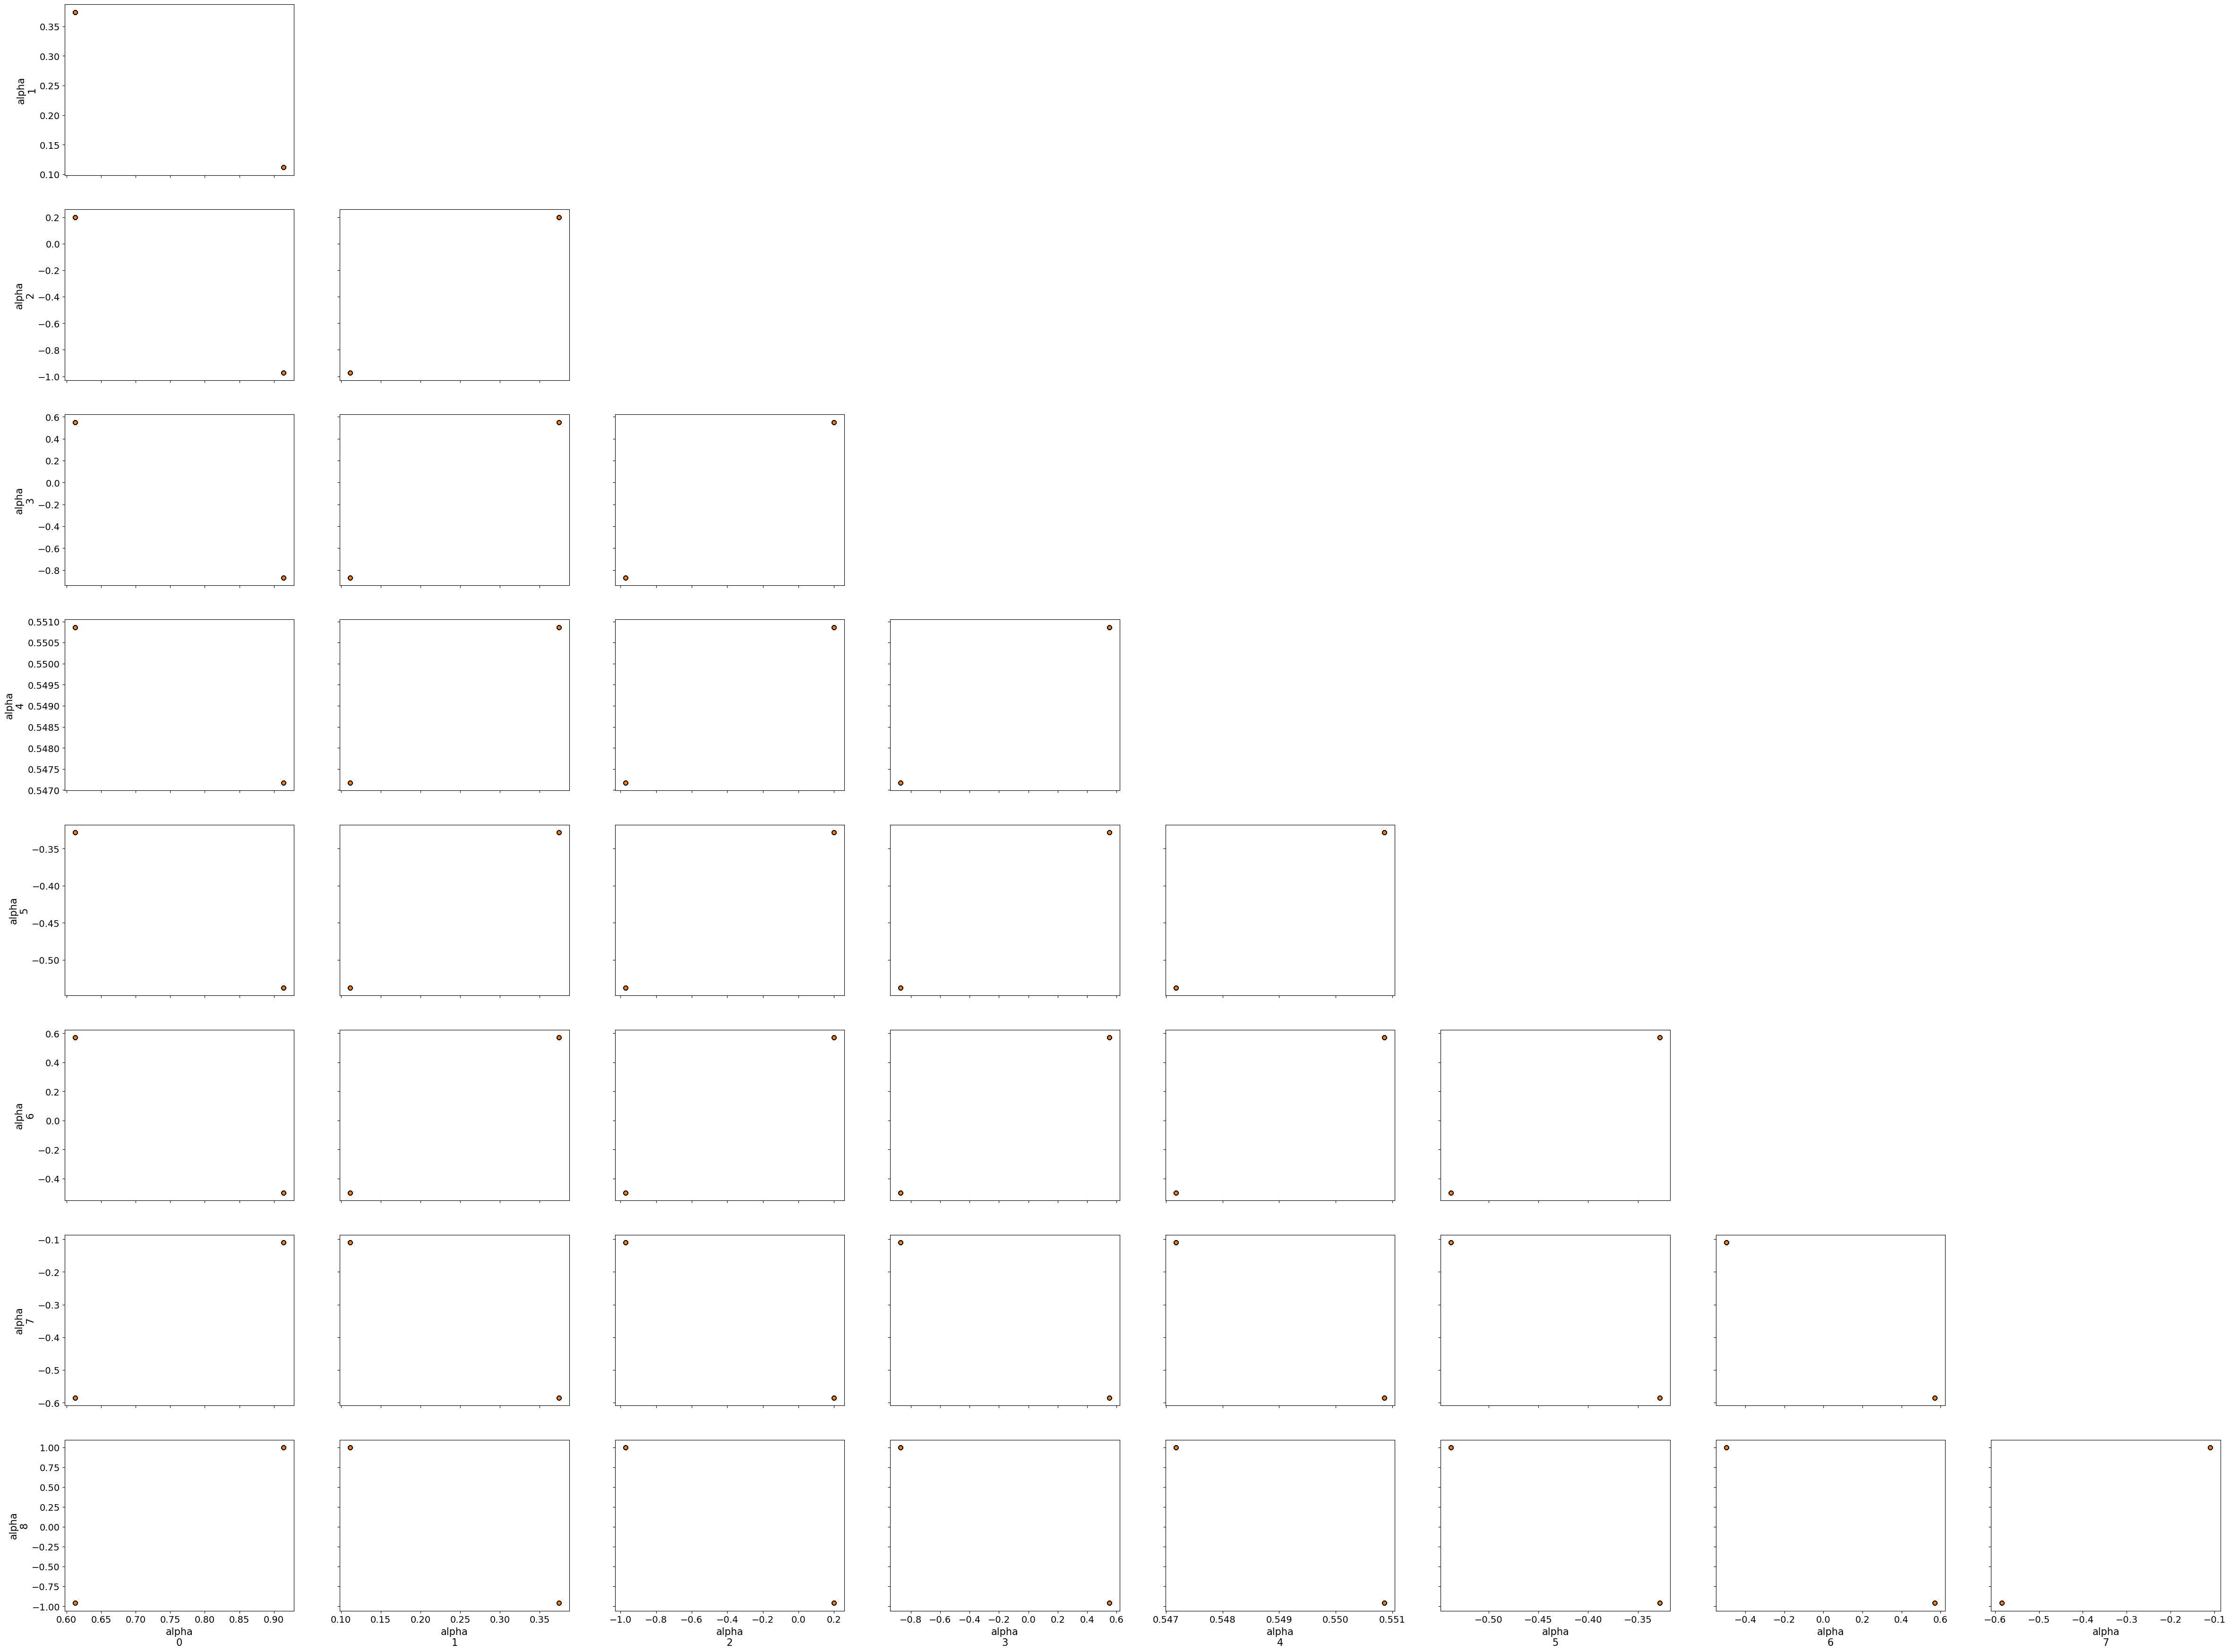

In [30]:
import arviz as az
az.plot_pair(posterior_samples, var_names=["alpha", "sigma"], divergences=True)